# Statistics of ideal mixing
Testing the sampling of the `SaltSwap` code by analysing a transformation where change in total energy should be exactly zero. Here, the non-bonded parameters of the two TIP3P water molecules are "exchanged" with the non-bonded parameters of two TIP3P water molecules, which are labelled as 'cations' and 'anions'. 

This notebook tests:
 1. Whether the `SaltSwap` code correctly samples from the target distribution. This is achieved by comparing simulation with an analytical formula for the null transformation described above.
 2. To quantify the shadow work accumulated during NCMC with a velocity Verlet propagation kernel and its affect on the acceptance rates.

In [1]:
# Loading modules and pretty colours

from simtk import openmm, unit
from simtk.openmm import app
from openmmtools.testsystems import WaterBox
import sys
sys.path.append("../saltswap/")
sys.path.append("../SAMS/")
from calibrate import MCMCSampler
from saltswap import SaltSwap
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

# Nice colours, taken on 26th Nov 2015 from:
#http://tableaufriction.blogspot.co.uk/2012/11/finally-you-can-use-tableau-data-colors.html

# These are the "Tableau" colors as RGB. I've chosen my faves. 
# In order: blue, green, purple, orange. Hopefully a good compromise for colour-blind people.
tableau4 = [(31, 119, 180),(44, 160, 44),(148,103,189),(255, 127, 14)]
tableau4_light = [(174,199,232),(152,223,138),(197,176,213),(255,187,120)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts. 
for i in range(len(tableau4)):    
    r, g, b = tableau4[i]    
    tableau4[i] = (r / 255., g / 255., b / 255.)
    r, g, b = tableau4_light[i]    
    tableau4_light[i] = (r / 255., g / 255., b / 255.)

As with other notebooks, the test system will be small box of water.

In [2]:
size = 20.0*unit.angstrom     
temperature = 300*unit.kelvin
pressure = 1*unit.atmospheres
delta_chem = 0*unit.kilojoule_per_mole
wbox = WaterBox(box_edge=size,nonbondedMethod=app.PME)
Nmols = wbox.system.getNumParticles()/3.0

# Chemical potential and average numbers

For the reaction when two water molecules are exchanged for an anion and cation pair that have equal interaction energies, the ratio of water molecules to salt molecules is given by

$$ \exp\left(-\frac{\beta\Delta \mu }{2}\right) = \frac{n_w}{n_s} $$

where $\beta\Delta \mu$ is the applied (dimentionless) difference in chemical potential between water and salt, and $n_w$ and $n_s$ are the number of water molecules and salt molecules respectively. The factor of 1/2 in the exponent comes from the fact that two water molecules are exchanged for two ions.

Below, a range of chemical potentials are applied to equilibrium sampling of instantaneous switching of 2 water molecules 2 two water molecules that are labelled as salt. The average number of molecules and ratios between water and 'salt' molecules are recorded.

In [4]:
mus = [-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2] # The chemical potentials

#mus = [0] # The chemical potentials

r = np.zeros(len(mus))      # mean ratio of water to salt
rstd = np.zeros(len(mus))   # standard deviation of water to salt
w = np.zeros(len(mus))      # mean number of waters
s = np.zeros(len(mus))      # mean number of salt pairs
acc_inst = np.zeros(len(mus))    # array to store acceptance rates

#Nsamps=500         # The mean number of samples per chemical potential
Nsamps = 200

for i in range(len(mus)):
    dummystate = MCMCSampler(wbox.system,wbox.topology,wbox.positions,delta_chem=mus[i])
    dummystate.saltswap.cation_parameters = dummystate.saltswap.water_parameters
    dummystate.saltswap.anion_parameters = dummystate.saltswap.water_parameters
    Nwats = []
    Nsalts = []
    ratio = []
    for block in range(Nsamps):
        dummystate.gen_label(saltsteps=20)
        (nwats,nsalt,junk) = dummystate.saltswap.getIdentityCounts()
        ratio.append(1.0*nwats/nsalt)
        Nwats.append(nwats)
        Nsalts.append(nsalt)
    w[i] = (np.array(Nwats)/Nmols).mean()  
    s[i] = (np.array(Nsalts)/Nmols).mean()
    ratio = np.array(ratio)
    r[i] = ratio[50:].mean()
    rstd[i] = ratio[50:].std()
    acc_inst[i] = dummystate.saltswap.getAcceptanceProbability()

The acceptance probabilities are given below:

In [6]:
print acc_inst

[ 0.8855  0.9005  0.885   0.889   0.8885  0.899   0.9     0.8735  0.9045
  0.921   0.896 ]


Comparing the sampled ratios of water to salt molecules to the analytical formula:

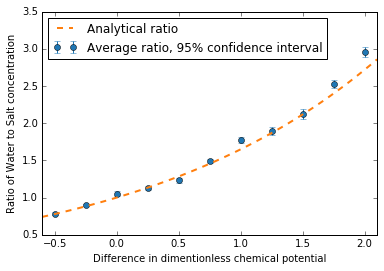

In [7]:
mus = np.array(mus)
delta = 0.1
xlims = (mus[0]-delta,mus[-1]+delta)
x = np.linspace(xlims[0],xlims[1])

plt.clf()
plt.errorbar(mus,r,yerr=2*rstd/np.sqrt(Nsamps),fmt='o',color=tableau4[0])
plt.plot(x,np.exp(np.array(x)/2), 'r--',linewidth=2,color=tableau4[3])
#plt.plot(mus,w/s,color=tableau4[1])
plt.xlim(xlims)
#plt.ylim((0.75,3))
plt.xlabel('Difference in dimentionless chemical potential')
plt.ylabel('Ratio of Water to Salt concentration')
plt.legend(['Analytical ratio','Average ratio, 95% confidence interval'],loc=2)
plt.show()

There appears to be reasonable agreement between theory and simulation, except at $\Delta \mu =0$, where the 95% confidense region does not overlap with the analytical formula. This may be due to numerical errors accumulated during the instant switching, investigated below. 

**SWITCHES WITH NCMC**

As above, performing null transformations (transforming 2 water molecules into 2 water molecules). This time, NCMC will be performed with velocity Verlet propagation  kernels with the parameters:

* Number of perturbation kernels = 512
* Number of propagation kernels = 1

In [11]:
mus = [-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2] # The chemical potentials
ncr = np.zeros(len(mus))
ncrstd = np.zeros(len(mus))
ncrstd = np.zeros(len(mus))
acc_nc = np.zeros(len(mus))
Nsamps = 200

for i in range(len(mus)):
    ncstate = MCMCSampler(wbox.system,wbox.topology,wbox.positions,delta_chem=mus[i],nkernels=100,nverlet=1,propagator='GHMC')
    ncstate.saltswap.cation_parameters = ncstate.saltswap.water_parameters
    ncstate.saltswap.anion_parameters = ncstate.saltswap.water_parameters
    ncratio = []
    for block in range(Nsamps):
        ncstate.gen_label(saltsteps=20)
        (nwats,nsalt,junk) = ncstate.saltswap.getIdentityCounts()
        ncratio.append(float(nwats)/float(nsalt))
    ratio = np.array(ncratio)
    ncr[i] = ratio.mean()#ratio[50:].mean()
    ncrstd[i] = ratio.std()#ratio[50:].std()
    acc_nc[i] = ncstate.saltswap.getAcceptanceProbability()

Exception: Particle coordinate is nan

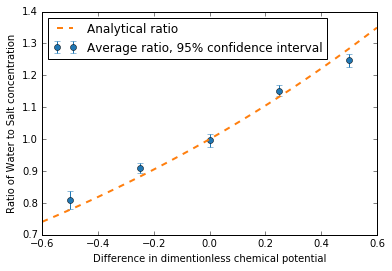

In [66]:
mus = np.array(mus[0:5])
delta = 0.1
xlims = (mus[0]-delta,mus[-1]+delta)
x = np.linspace(xlims[0],xlims[1])

plt.clf()
plt.errorbar(mus,ncr[0:5],yerr=2*ncrstd[0:5]/np.sqrt(Nsamps),fmt='o',color=tableau4[0])
plt.plot(x,np.exp(np.array(x)/2), 'r--',linewidth=2,color=tableau4[3])
plt.xlim(xlims)
#plt.ylim((0.75,3))
plt.xlabel('Difference in dimentionless chemical potential')
plt.ylabel('Ratio of Water to Salt concentration')
plt.legend(['Analytical ratio','Average ratio, 95% confidence interval'],loc=2)
plt.savefig('GHMC_ncmc.png',format='png')
#Image('GHMC_ncmc.png')

## Work distributions due to shadow work
Looking at the distribution of the shadow work

In [73]:
print "Energy (in kT) to change parameters in one direction = {0} +/- {1:4f}".format(np.mean(ncstate.saltswap.work_add),np.std(ncstate.saltswap.work_add))
print "Energy (in kT) to change parameters in one direction = {0} +/- {1:4f}".format(np.mean(ncstate.saltswap.work_rm),np.std(ncstate.saltswap.work_rm))

Energy to change parameters in one direction = 7.63477058423e-08 +/- 0.000083
Energy to change parameters in one direction = -3.77160607681e-07 +/- 0.000080


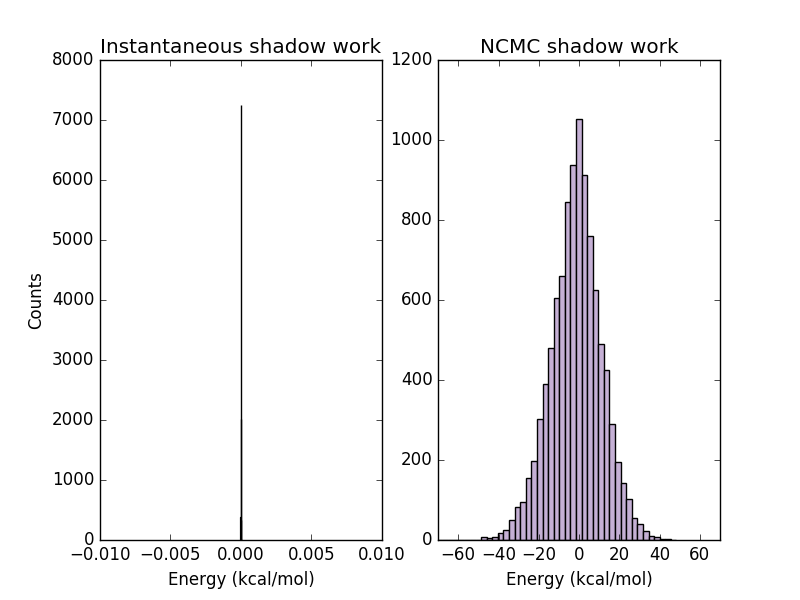

In [92]:
plt.clf()
#n, bins, patches = plt.hist(nc_work_rm, 50, normed=1, facecolor=tableau4_light[2])

plt.savefig('temp.png',format='png')
Image('temp.png')

f, axarr = plt.subplots(1, 2)
coords = [(0,0),(0,1)]
xlims =(-70,70)       # x limits
ylims = (0,0.025)       # y limits


axarr[0].hist(np.hstack((inst_work_add,inst_work_rm))*0.592, 5, normed=False, facecolor=tableau4_light[2])
axarr[0].set_xlim({-0.01,0.01})
#axarr[0].set_xlim(xlims)
#axarr[0].set_ylim(ylims)
axarr[0].set_xlabel('Energy (kcal/mol)')
axarr[0].set_ylabel('Counts')
axarr[0].set_title('Instantaneous shadow work')
axarr[1].hist(np.hstack((nc_work_add,nc_work_rm))*0.592, 50, normed=False, facecolor=tableau4_light[2])
axarr[1].set_xlim(xlims)
#axarr[1].set_ylim(ylims)
axarr[1].set_xlabel('Energy (kcal/mol)')
axarr[1].set_title('NCMC shadow work')
#plt.setp(axarr[1].get_yticklabels(),visible=False)  

plt.savefig("ShadowWork.png", format='png')
Image("ShadowWork.png")